# Wasserstein GAN

### 기존 GAN 의 한계

$$  \min_G \max_D V(G,D) = \mathbb{E}_{x \sim p_{data}(x)}[logD(x)] + \mathbb{E}_{z \sim p_{g}(z)}[logD(G(z))] $$

GAN은 생성자와 판별자간의 관계를 학습시킴으로서 생성자의 분포를 $p_{data}(x)$ 에 가깝게 학습시키려고 한다.  
그러나 GAN에서는 생성자와 판별자가 균형을 유지하며 학습하기 어렵고 학습이 완료된 이후에도 mode dropping / collapse 이 발생한다는 문제점이 있다.

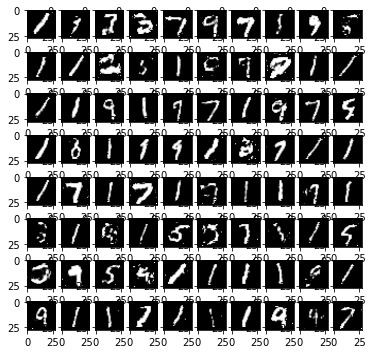

예를 들면 생성자가 1을 만들어내는데 판별자의 학습이 저조하여 생성자의 1과 기존 데이터의 1을  
구분을 못하게 되어 생성자는 1을 계속 생성하게 되는 경우

### WGAN vs GAN

WGAN 과 GAN의 차이점을 간단히 요약하면  

1. $p_{data}(x)$ 와 $p_g(z)$ 간의 거리를 줄여나가기 위해 GAN에서 KL divergence를 이용했다면 WGAN 은 EM(Earth Mover) distance를 이용했다.

2. GAN의 판별자 대신 WGAN에서는 critic 을 사용한다. GAN의 판별자가 real or fake에 대한 확률을 출력했다면 critic은 EM distance 로 부터 얻은 스칼라값을 사용한다.

결과적으로 학습 안정성이 향상되고, mode collapse 와 같은 문제들이 사라졌다.

### EM distance ?

다음 식들은 확률 분포간의 거리를 구하기 위해 정의된 식들

1. Total Variation distance  

$$ δ(\mathbb{P}_{r},\mathbb{P}_{g}) = \sup_{A\inΣ} \lvert \mathbb{P}_{r}(A) - \mathbb{P}_{g}(A) \rvert $$  

2. Kullback-Leibler divergence  

$$ KL(\mathbb{P}_{r}||\mathbb{P}_{g}) = \int log \left( \frac{\mathbb{P}_{r}(x)}{\mathbb{P}_{g}(x)}\right) \mathbb{P}_{r}(x)dμ(x) $$  

3. Jensen-Shannon divergence  

$$ JS(\mathbb{P}_{r},\mathbb{P}_{g}) = KL(\mathbb{P}_{r}||\mathbb{P}_{m}) + KL(\mathbb{P}_{g}||\mathbb{P}_{m})$$  
$$\mathbb{P}_{m} = (\mathbb{P}_{r}+\mathbb{P}_{g})/2 $$  

4. Earth-Mover distance  

$$ W(\mathbb{P}_{r},\mathbb{P}_{g}) = \inf_{γ\in\prod(\mathbb{P}_{r},\mathbb{P}_{g})} \mathbb{E}_{(x,y) \sim γ}[ ||x-y|| ] $$

이때 위의 3개는 두 분포가 겹치거나 겹치지 않을때 값이 0에서 무한대로 크게 변동하여 학습에 적합하지 않다.  

이제 Kantorovich-Rubinstein duality 를 이용하여 식을 수정하면  
$$W(\mathbb{P}_{r},\mathbb{P}_{g}) = \sup_{||f||_{L}\leq1}\mathbb{E}_{x \sim \mathbb{P}_r}[f(x)] - \mathbb{E}_{x \sim \mathbb{P}_g}[f(x)] $$  

이것을 학습시키기 위한 형태로 바꾸면

$$ \max_{w \in 𝑾} \mathbb{E}_{x \sim \mathbb{P}_r}[f_w(x)] - \mathbb{E}_{z \sim p(z)}[f_w(g_\theta(z))] $$  
이때 립시츠 조건을 만족시키기 위해 학습 시 계속 clipping 을 해준다
이렇게 되는데 여전히 $\mathbb{P}_r$ 텀이 존재하지만 나중에 $θ$ 에 대해서 미분할때 사라진다.

### 실험 결과

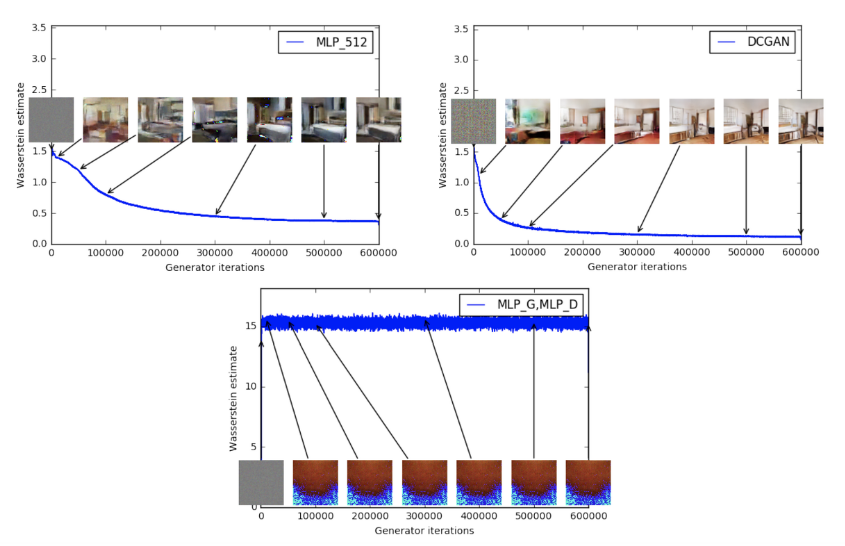

위의 두개는 기존의 판별자 대신 critic을 아래는 기존의 GAN 모델로 EM distance를 확인

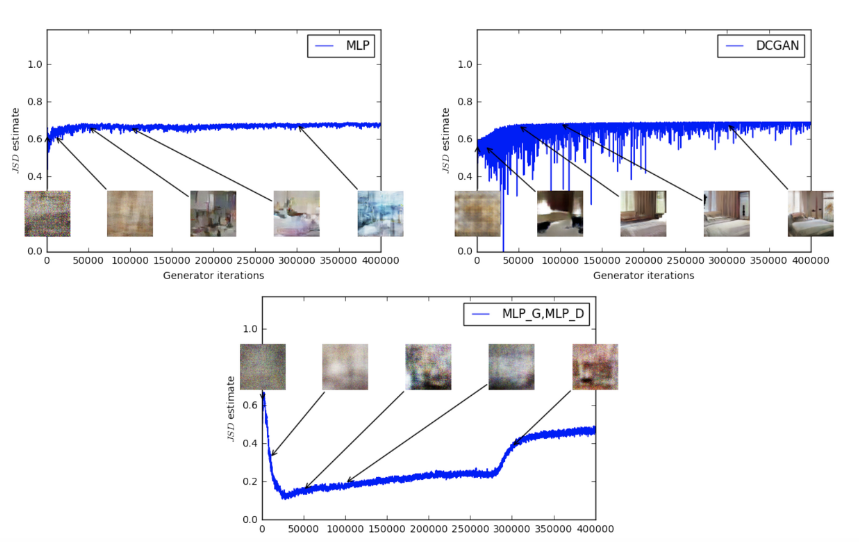

똑같은 구조로 JS distance 가 수렴함을 확인

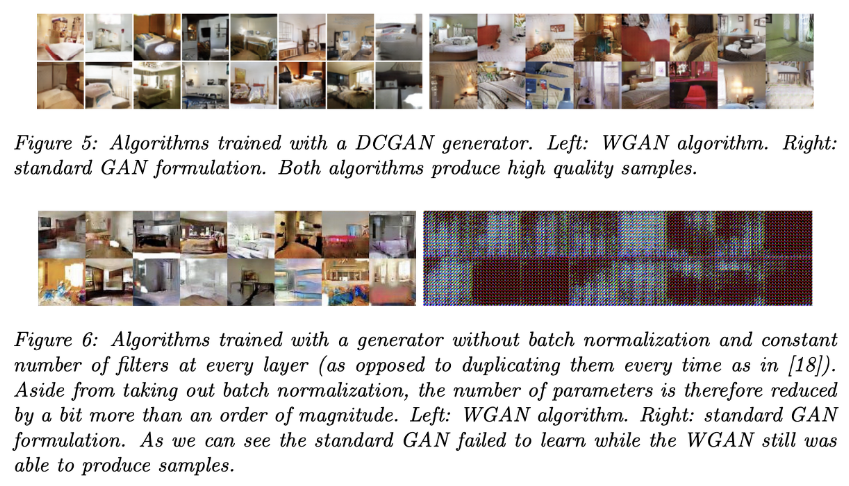

# 코드 실습

In [ ]:
# 라이브러리 임포트
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils

import matplotlib.pyplot as plt
import numpy as np
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 코랩에서 unzip하기

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Datasets

!unzip -qq "/content/drive/MyDrive/Colab Notebooks/Datasets/archive.zip"

/content/drive/MyDrive/Colab Notebooks/Datasets


In [ ]:
# 변수 정의

workers = 16
batch_size = 128
image_size = 32

nc = 3
nz = 100
ngf = 32
ndf = 32

num_epochs = 20
n_critics = 5
lr = 0.0001
weight_cliping_limit = 0.01
beta1 = 0.5
fig_keyframes = 20
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

ngpu = 1
device = torch.device('cuda' if (torch.cuda.is_available() and ngpu > 0) else 'cpu')

In [ ]:
os.listdir('/content/drive/MyDrive/Colab Notebooks/Datasets/CelebA')

['img_align_celeba']

In [ ]:
ls -a

./  ../  .config/  drive/  sample_data/


In [ ]:
# 데이터 로드
base_path = '/content/drive/MyDrive/Colab Notebooks/Datasets/'
train_dataset = datasets.ImageFolder(root=base_path+'CelebA/',
                                     transform=transforms.Compose([
                                                                    transforms.Resize(image_size),
                                                                    transforms.CenterCrop(image_size),
                                                                    transforms.ToTensor(),
                                                                    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                                                    ]))
dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size,  
                                         shuffle=True, num_workers=workers)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


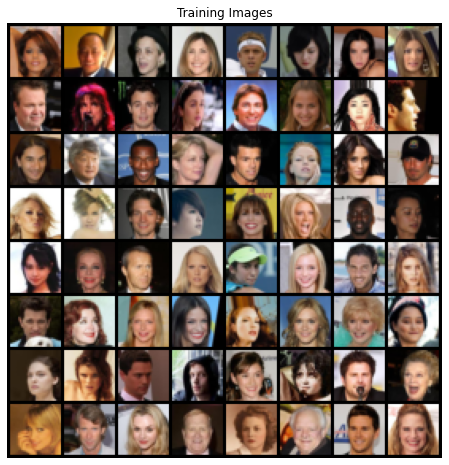

In [ ]:
one_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Training Images')
plt.imshow(np.transpose(vutils.make_grid(one_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [ ]:
# DCGAN 구현
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, nc, 4, 2, 1, bias=False),
            nn.Tanh()

        )
    def forward(self, input):
      return self.main(input)
      
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf * 2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            # nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
netG = Generator().to(device)
netD = Discriminator().to(device)

netG.apply(weights_init)
netD.apply(weights_init)

real_label = 1.
fake_label = 0.

optimizerD = torch.optim.RMsprop(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.RMsprop(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
import tqdm
from tqdm.notebook import tqdm as tqdm_nb
import warnings
warnings.filterwarnings("ignore")

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

img_list = []
G_losses = []
D_losses = []

total_steps = num_epochs * len(dataloader)
fig_save_interval = total_steps // fig_keyframes

pbar = tqdm_nb()
piter = 0

num_epochs = 50
print("Starting Training Loop...")

for epoch in range(num_epochs):

    epoch_steps = len(dataloader)
    pbar.reset(total=epoch_steps)
    for i, data in enumerate(dataloader, 0):
        pbar.update()
        piter += 1
        # D 학습
        netD.zero_grad()
        
        real_img = data[0].to(device)
        b_size = real_img.size(0)
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_img = netG(noise)
        
        errD = -torch.mean(netD(real_img)) + torch.mean(netD(fake_img)) # Wasserstein
        errD.backward()
        optimizerD.step()
        
        # Clipping
        for p in netD.parameters():
            p.data.clamp_(-weight_cliping_limit, weight_cliping_limit) # numbers from a paper
        
        # G 학습
        if i % n_critics == 0:
            
            netG.zero_grad()

            gen_img = netG(noise)
            errG = -torch.mean(netD(gen_img))
            errG.backward()
            optimizerG.step()

            desc = '[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f' \
                    % (epoch+1, num_epochs, i, epoch_steps, errD.item(), errG.item())
            pbar.set_description(desc)

            G_losses.append(errG.item())
            D_losses.append(errD.item())

        # fake image 생성
        if (piter - 1) % fig_save_interval == 0:
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append((epoch+1, i, vutils.make_grid(fake, padding=2, normalize=True)))
            print(desc)

pbar.refresh()


0it [00:00, ?it/s]

Starting Training Loop...
[1/50][0/501] Loss_D: -0.2258 Loss_G: 0.0025
[2/50][0/501] Loss_D: -0.3605 Loss_G: 0.2127
[3/50][0/501] Loss_D: -0.2641 Loss_G: 0.1531
[4/50][0/501] Loss_D: -0.2611 Loss_G: 0.1771
[5/50][0/501] Loss_D: -0.2881 Loss_G: 0.2042
[6/50][0/501] Loss_D: -0.2824 Loss_G: 0.1546
[7/50][0/501] Loss_D: -0.2444 Loss_G: 0.1627
[8/50][0/501] Loss_D: -0.2682 Loss_G: 0.1740
[9/50][0/501] Loss_D: -0.2579 Loss_G: 0.1609
[10/50][0/501] Loss_D: -0.2470 Loss_G: 0.1570
[11/50][0/501] Loss_D: -0.2169 Loss_G: 0.1521
[12/50][0/501] Loss_D: -0.2141 Loss_G: 0.1395
[13/50][0/501] Loss_D: -0.1769 Loss_G: 0.1171
[14/50][0/501] Loss_D: -0.2066 Loss_G: 0.1593
[15/50][0/501] Loss_D: -0.1965 Loss_G: 0.1472
[16/50][0/501] Loss_D: -0.1801 Loss_G: 0.1086
[17/50][0/501] Loss_D: -0.1719 Loss_G: 0.1283
[18/50][0/501] Loss_D: -0.1869 Loss_G: 0.1135
[19/50][0/501] Loss_D: -0.1867 Loss_G: 0.1250
[20/50][0/501] Loss_D: -0.1664 Loss_G: 0.1076
[21/50][0/501] Loss_D: -0.1721 Loss_G: 0.1175
[22/50][0/501] Lo

True

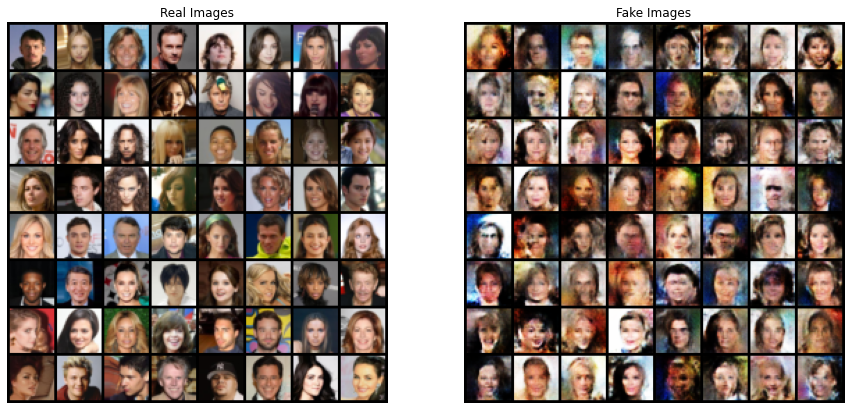

In [ ]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(15, 15))

plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1][-1],(1,2,0)))
plt.show()

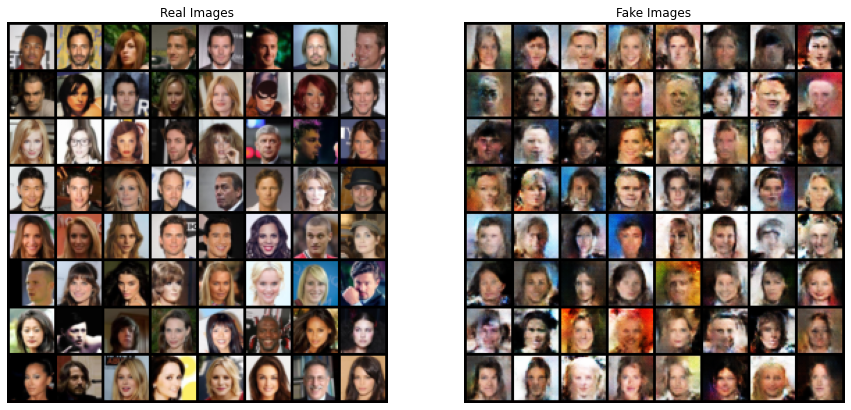

In [ ]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(15, 15))

plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1][-1],(1,2,0)))
plt.show()

In [ ]:
# https://www.kaggle.com/code/joonasyoon/wgan-cp-with-celeba-and-lsun-dataset/notebook